In [51]:
# camera calibration
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

#read in all images
images = glob.glob('camera_cal/calibration*.jpg')


objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


for fname in images:
    #read in each image
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
 


In [52]:
#load in one image to get the shape
img = mpimg.imread('camera_cal/calibration1.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) #just to get the shape
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

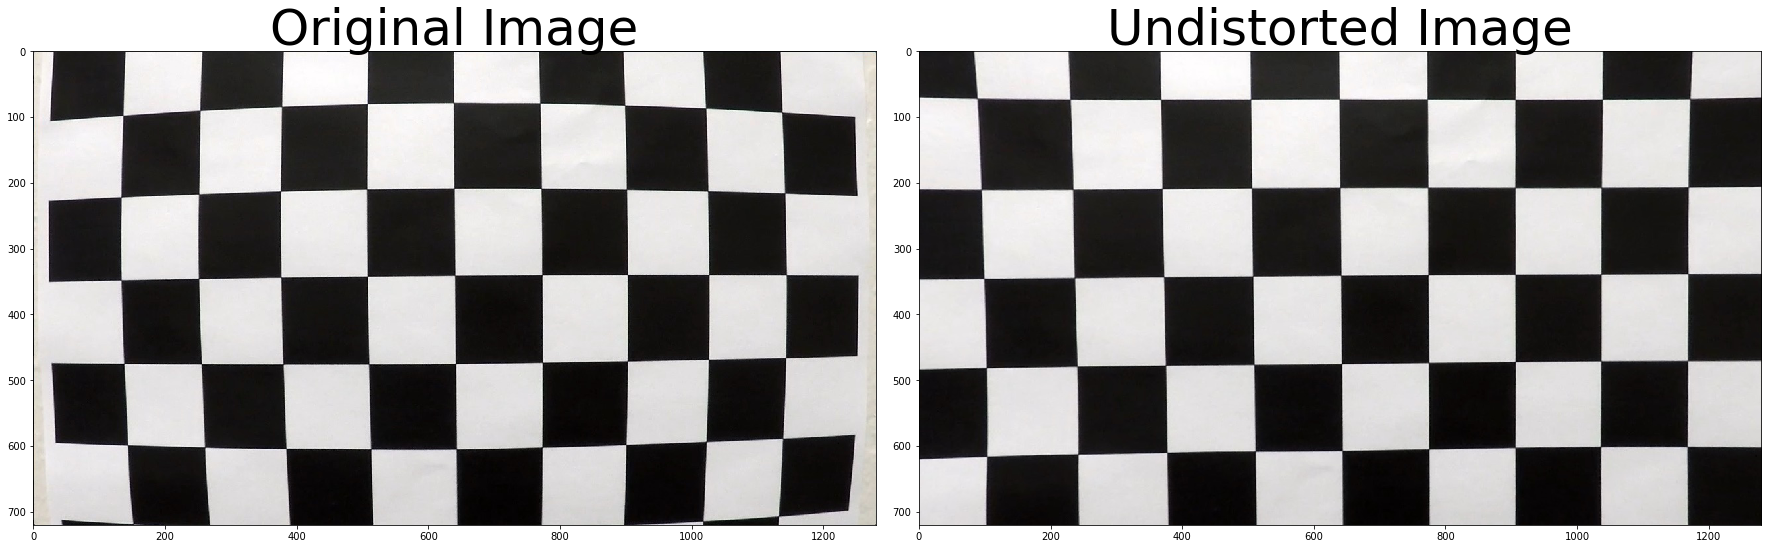

In [53]:
#show one example

dst = cv2.undistort(img, mtx, dist, None, mtx)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

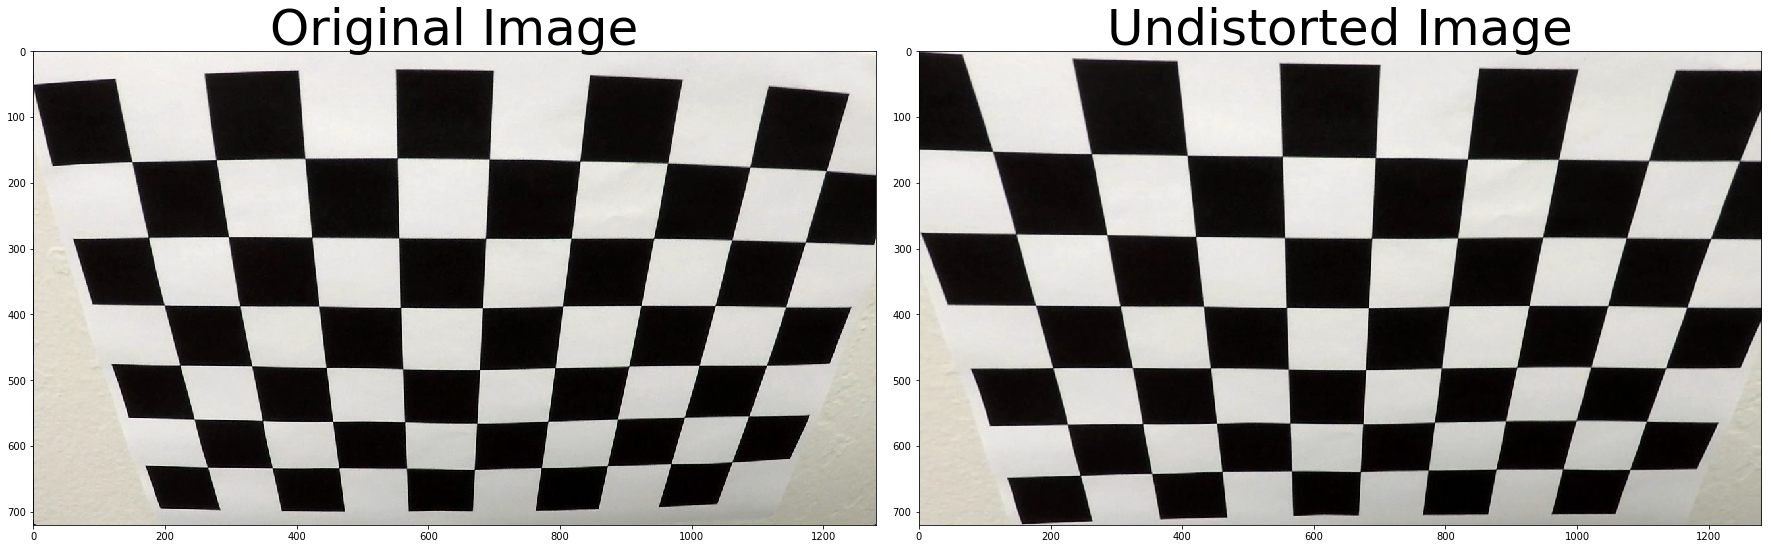

In [54]:
#show another example
img2 = mpimg.imread('camera_cal/calibration2.jpg')
dst2 = cv2.undistort(img2, mtx, dist, None, mtx)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst2)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [55]:
#save the calibration result 
import pickle
camera_calib_dict = {}
camera_calib_dict['mtx'] = mtx
camera_calib_dict['dist'] = dist
camera_calib_dict['rvecs'] = rvecs
camera_calib_dict['tvecs'] = tvecs
with open('calibration.p','wb') as f:
    pickle.dump(camera_calib_dict, f)
f.close()
    

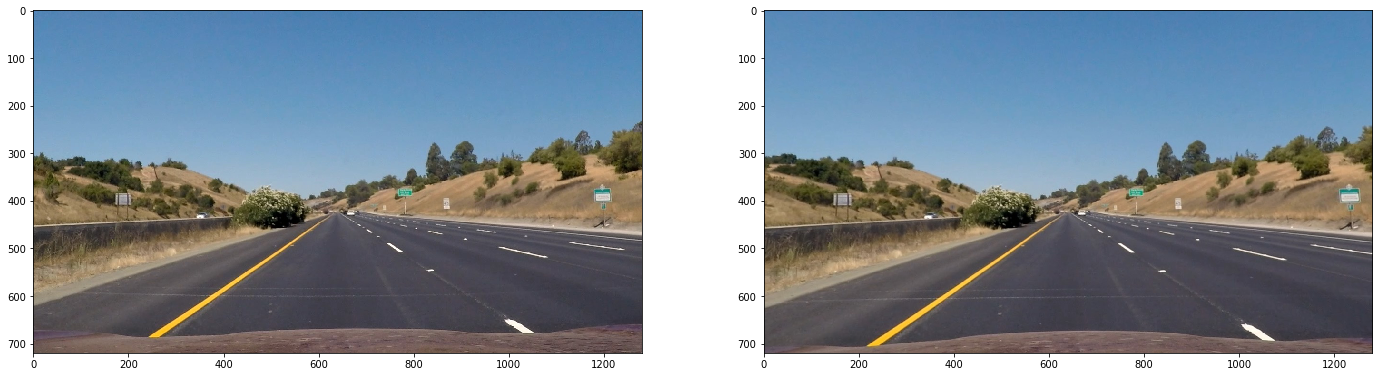

In [203]:
# start from straight lanes 
test_image = mpimg.imread('test_images/straight_lines1.jpg')
dst_test = cv2.undistort(test_image, mtx, dist, None, mtx)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(test_image)
ax2.imshow(dst_test)


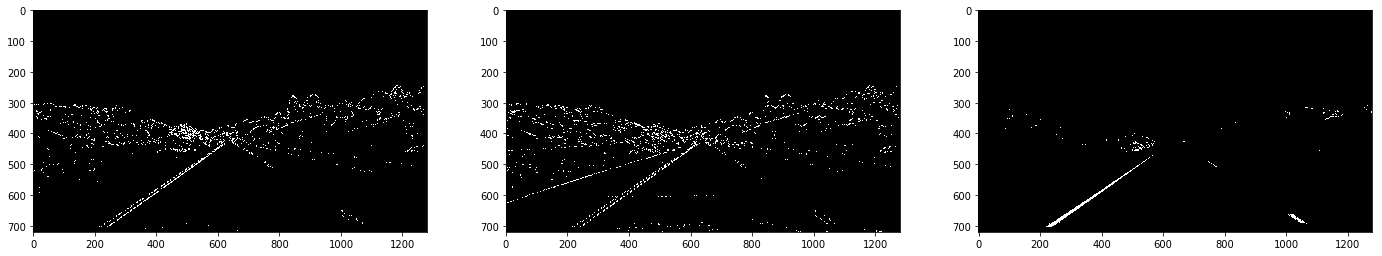

In [204]:
#thresholding pipeline to detect the edges
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    sobelmag = np.sqrt(np.sum([np.square(sobelx), np.square(sobely)], axis=0 ))
    scaled_sobel = np.uint8(255*sobelmag/np.max(sobelmag))

    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    sobel_angle = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(sobel_angle)
    dir_binary[(sobel_angle >= thresh[0]) & (sobel_angle <= thresh[1])] = 1
    return dir_binary

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(dst_test, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(dst_test, orient='y', sobel_kernel=ksize, thresh=(20, 100))
gradient_binary = np.zeros_like(grady)
#combine absolute gradients
gradient_binary[(gradx == 1) & (grady == 1)] = 1
mag_binary = mag_threshold(dst_test, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(dst_test, sobel_kernel=15, thresh=(0.7, 1.3))
#combine magnitude and directional threshold
mag_dir_binary = np.zeros_like(dir_binary)
mag_dir_binary[(mag_binary == 1) & (dir_binary == 1)] = 1
#hls colorspace
hls_binary = hls_select(dst_test, thresh=(190, 255))
%matplotlib inline
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
#show the three threshold
ax1.imshow(gradient_binary, cmap='gray')     
ax2.imshow(mag_dir_binary,cmap='gray')    
ax3.imshow(hls_binary,cmap='gray')    




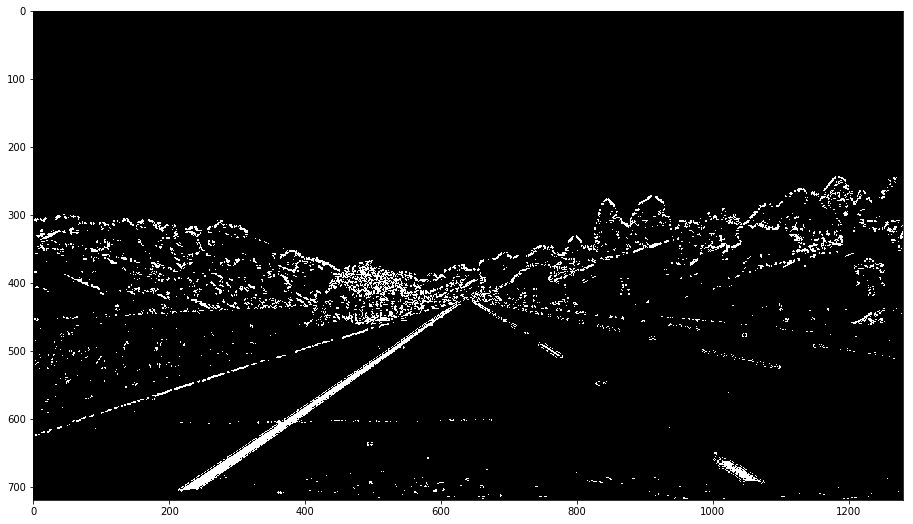

In [205]:
combined_binary = np.zeros_like(hls_binary)
combined_binary[(gradient_binary == 1) | (mag_dir_binary == 1)|(hls_binary == 1)] = 1
%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(24, 9))
#show the resulting image combing three threshold
ax.imshow(combined_binary, cmap= 'gray')                    


(1280, 720)


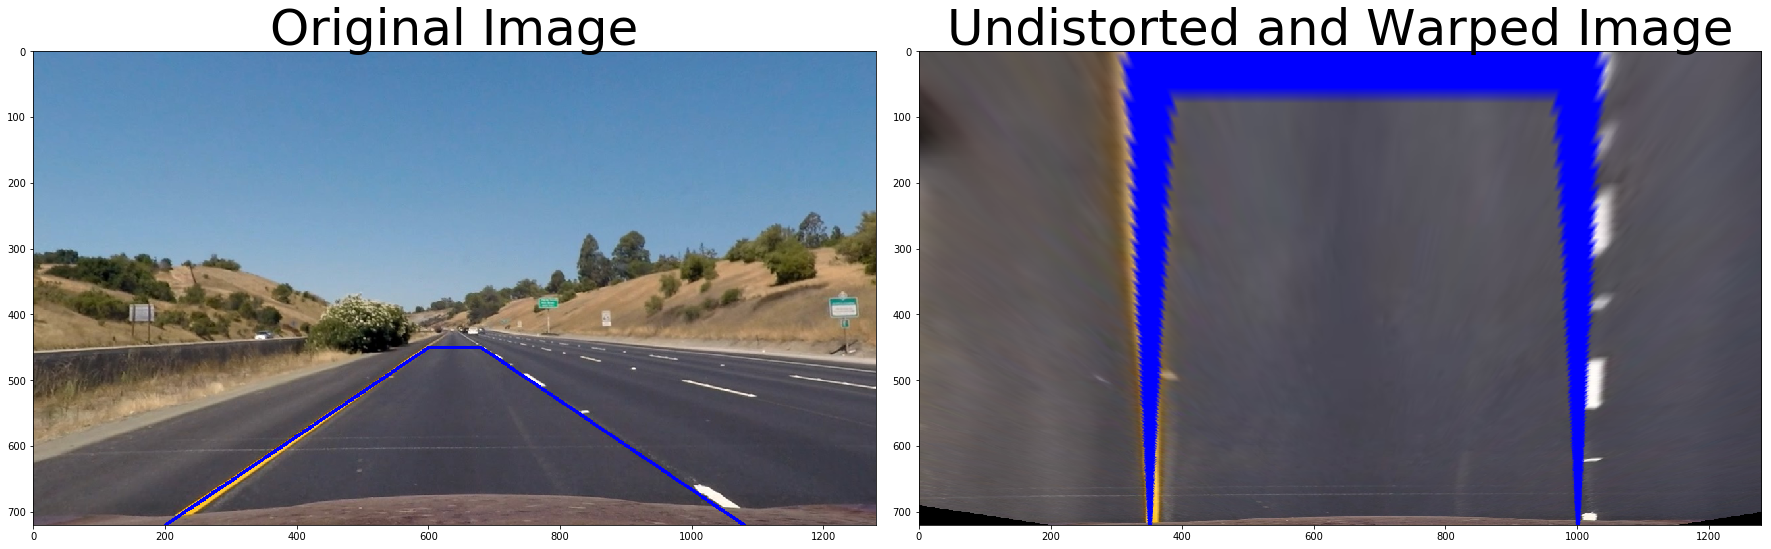

In [206]:
#perspective transform 
img_size =(combined_binary.shape[1], test_image.shape[0])
#TUNE the points until the lanes are parallel
src = np.float32([[600,450],[680,450], [1080, img_size[1]], [200, img_size[1]]])
src = src.reshape((-1,1,2))
#(600,450),(680,450),(1080,720), (200,720)
dst_test_overlay = cv2.line(dst_test,(600,450),(680,450),(0,0,255),3)
dst_test_overlay = cv2.line(dst_test,(680,450),(1080,img_size[1]),(0,0,255),3)
dst_test_overlay = cv2.line(dst_test,(600,450),(200,img_size[1]),(0,0,255),3)
dst = np.float32([[350,0],[1000,0],[1000, img_size[1]],[350, img_size[1]]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst, src)
dst_test_warped = cv2.warpPerspective(dst_test_overlay, M, img_size, flags=cv2.INTER_LINEAR)
%matplotlib inline
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst_test_overlay)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dst_test_warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



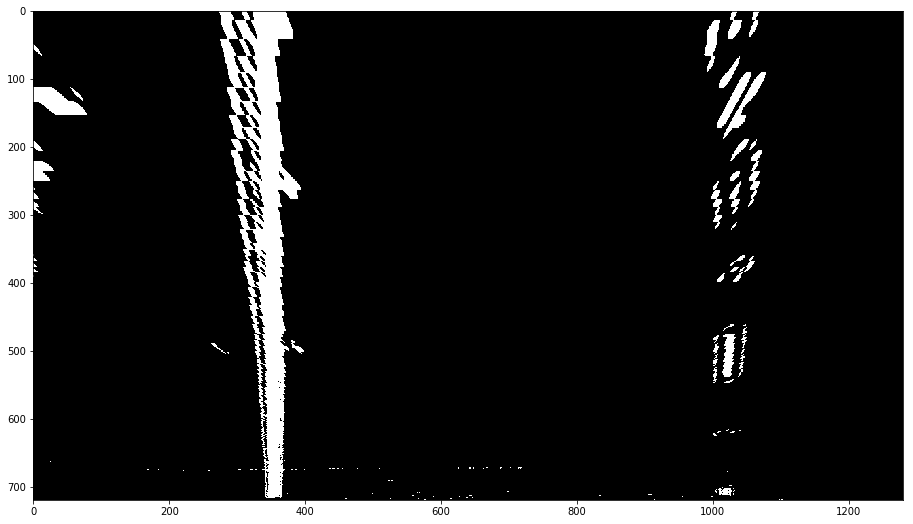

In [207]:
#apply the perspective transform on the binary image
binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(24, 9))
#show the resulting image combing three threshold
ax.imshow(out_img)        


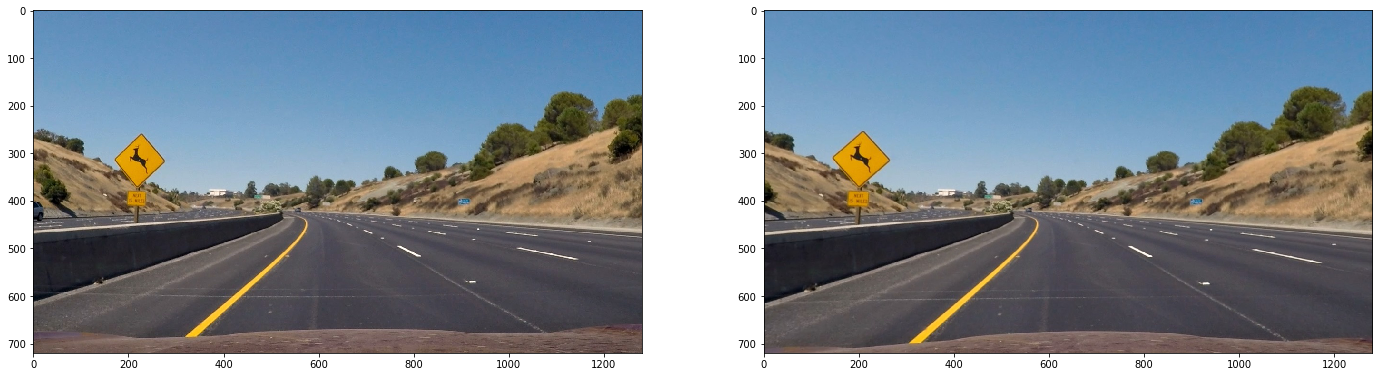

In [208]:
#detect lanes

#apply on a test image
test_image2 = mpimg.imread('test_images/test2.jpg')
dst_test2 = cv2.undistort(test_image2, mtx, dist, None, mtx)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(test_image2)
#print(test_image2.shape)
ax2.imshow(dst_test2)


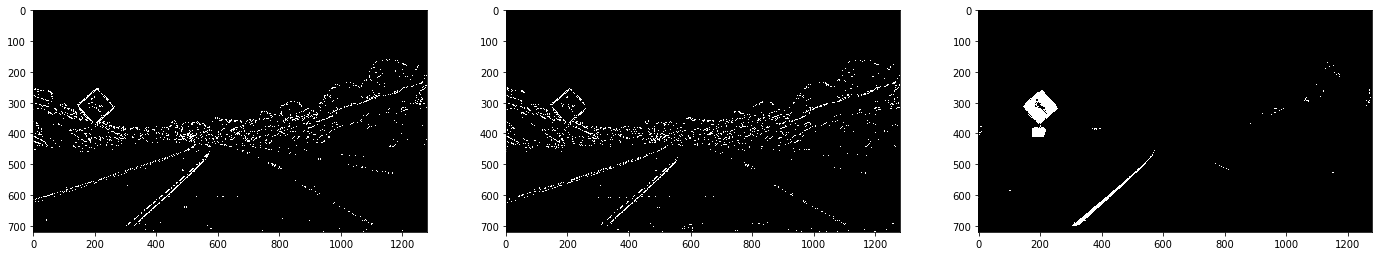

In [209]:
# Apply each of the thresholding functions
gradx = abs_sobel_thresh(dst_test2, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(dst_test2, orient='y', sobel_kernel=ksize, thresh=(20, 100))
gradient_binary = np.zeros_like(grady)
#combine absolute gradients
gradient_binary[(gradx == 1) & (grady == 1)] = 1
mag_binary = mag_threshold(dst_test2, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(dst_test2, sobel_kernel=15, thresh=(0.7, 1.3))
#combine magnitude and directional threshold
mag_dir_binary = np.zeros_like(dir_binary)
mag_dir_binary[(mag_binary == 1) & (dir_binary == 1)] = 1
#hls colorspace
hls_binary = hls_select(dst_test2, thresh=(190, 255))
%matplotlib inline
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(24, 9))
#show the three threshold
ax1.imshow(gradient_binary, cmap='gray')     
ax2.imshow(mag_dir_binary,cmap='gray')    
ax3.imshow(hls_binary,cmap='gray')    


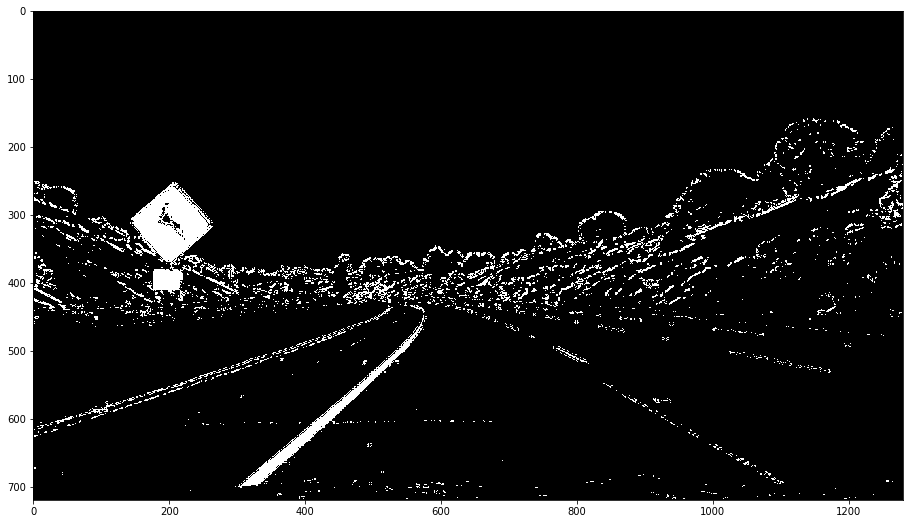

In [210]:
combined_binary = np.zeros_like(hls_binary)
combined_binary[(gradient_binary == 1) | (mag_dir_binary == 1)|(hls_binary == 1)] = 1
%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(24, 9))
#show the resulting image combing three threshold
ax.imshow(combined_binary, cmap= 'gray')                    


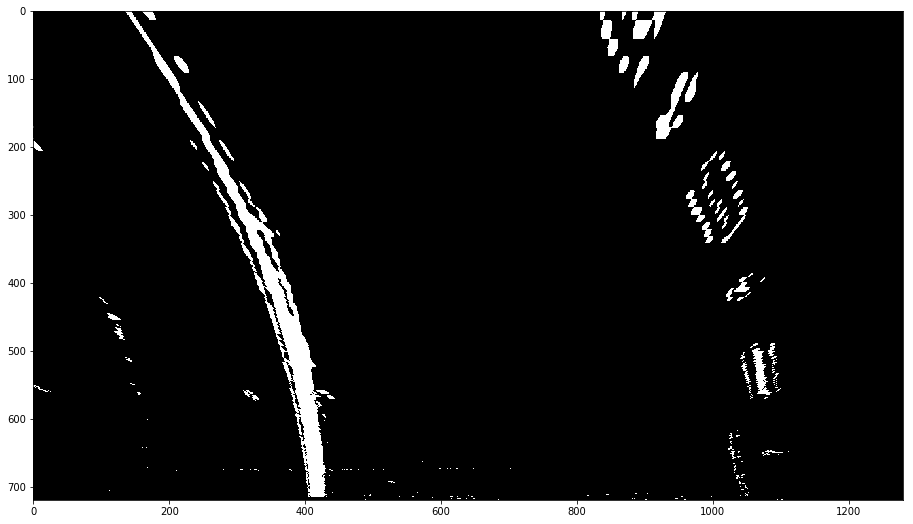

In [211]:
#apply the perspective transform on the binary image
binary_warped = cv2.warpPerspective(combined_binary, M, img_size, flags=cv2.INTER_LINEAR)
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
%matplotlib inline
f, ax = plt.subplots(1, 1, figsize=(24, 9))
#show the resulting image combing three threshold
ax.imshow(out_img)        


(720, 1280)


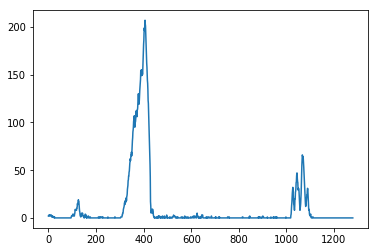

In [212]:
print(binary_warped.shape)

histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)


In [213]:
midpoint = np.int(histogram.shape[0]/2)
#Peak on the left
leftx_base = np.argmax(histogram[:midpoint])
print(leftx_base)
#peak on the right
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
print(rightx_base)

406
1067


(720, 0)

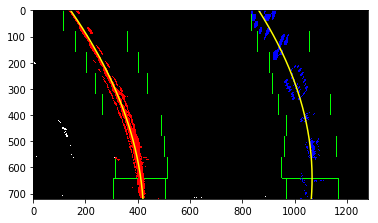

In [214]:
#detect lanes for the image
nwindows = 9
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)


# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

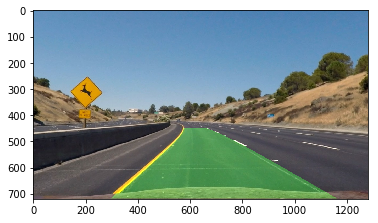

In [215]:
# project back onto the original image
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (test_image2.shape[1], test_image2.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(dst_test2, 1, newwarp, 0.3, 0)
plt.imshow(result)

In [216]:
#calculate curvature

y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad,'pixel',right_curverad,'pixel')


#pixel to real world
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m


1166.4525542712677 pixel 1019.1964730613497 pixel
380.0966781973619 m 331.9094007189519 m


In [15]:
#initialize line class to track
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [287]:
#define pipeline
def calibrate_camera():
    #read in all images
    images = glob.glob('camera_cal/calibration*.jpg')
    objpoints = []
    imgpoints = []
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    for fname in images:
        #read in each image
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

def calculate_perspective_transform():
    #TUNE the points until the lanes are parallel
    src = np.float32([[600,450],[680,450], [1080, img_size[1]], [200, img_size[1]]])
    src = src.reshape((-1,1,2))
    dst = np.float32([[350,0],[1000,0],[1000, img_size[1]],[350, img_size[1]]])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def undistort(img, mtx, dist):
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image

def apply_threshold(img, ksize, thresh, mag_thresh, sobel_kernel, angle_thesh, hls_thresh):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(20, 100))
    gradient_binary = np.zeros_like(grady)
    #combine absolute gradients
    gradient_binary[(gradx == 1) & (grady == 1)] = 1
    mag_binary = mag_threshold(img, sobel_kernel=ksize, mag_thresh=mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=sobel_kernel, thresh=angle_thesh)
    #combine magnitude and directional threshold
    mag_dir_binary = np.zeros_like(dir_binary)
    mag_dir_binary[(mag_binary == 1) & (dir_binary == 1)] = 1
    #hls colorspace
    hls_binary = hls_select(img, thresh=hls_thresh)
    combined_binary = np.zeros_like(hls_binary)
    combined_binary[(gradient_binary == 1) | (mag_dir_binary == 1)|(hls_binary == 1)] = 1
    return combined_binary

def apply_perspective_transform(img, M):
    img_size = (img.shape[1],img.shape[0])
    binary_warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return binary_warped

def fit_lane(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    #Peak on the left
    leftx_base = np.argmax(histogram[:midpoint])
    #peak on the right
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx

def find_lane_next_frame(binary_warped):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx
    
def draw_zone(binary_warped, original_img, undistorted_img, eft_fitx, right_fitx, ploty, Minv):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (original_img.shape[1], original_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    return result

def calculate_curvature(ploty, left_fitx, right_fitx):
#     y_eval = np.max(ploty)
#     left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
#     right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad,'pixel',right_curverad,'pixel')

    #pixel to real world
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def detect_lane(img, mtx, dist,ksize, thresh, mag_thresh, sobel_kernel, angle_thesh, hls_thresh, M, Minv):
    undistorted_image = undistort(img, mtx, dist)
    binary_image = apply_threshold(undistorted_image, ksize, thresh, mag_thresh, sobel_kernel, angle_thesh, hls_thresh)
    binary_image_warped = apply_perspective_transform(binary_image, M)
    out_img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx = fit_lane(binary_image_warped)
    result = draw_zone(binary_image_warped,img,undistorted_image, left_fitx, right_fitx, ploty, Minv)
    left_curverad, right_curverad = calculate_curvature(ploty, left_fitx, right_fitx)
    cv2.putText(result, "left radius:"+ str(int(left_curverad))+'m', (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
    cv2.putText(result, "right radius:"+ str(int(right_curverad))+'m', (20, 160), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
    return result

def detect_lane_by_default(img):
    ret, mtx, dist, rvecs, tvecs = calibrate_camera()
    M, Minv = calculate_perspective_transform()
    mag_thresh=(30, 100)
    angle_thesh=(0.7, 1.3)
    hls_thresh=(190, 255)
    sobel_kernel = 15
    ksize =3 
    undistorted_image = undistort(img, mtx, dist)
    binary_image = apply_threshold(undistorted_image, ksize, thresh, mag_thresh, sobel_kernel, angle_thesh, hls_thresh)
    binary_image_warped = apply_perspective_transform(binary_image, M)
    out_img, leftx, lefty, rightx, righty, ploty, left_fitx, right_fitx = fit_lane(binary_image_warped)
    result = draw_zone(binary_image_warped,img,undistorted_image, left_fitx, right_fitx, ploty, Minv)
    left_curverad, right_curverad = calculate_curvature(ploty, left_fitx, right_fitx)
    cv2.putText(result, "left radius:"+ str(int(left_curverad))+'m', (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
    cv2.putText(result, "right radius:"+ str(int(right_curverad))+'m', (20, 160), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255))
    return result


In [288]:
#input 
thresh=(20, 100)
mag_thresh=(30, 100)
angle_thesh=(0.7, 1.3)
hls_thresh=(190, 255)
sobel_kernel = 15
ksize =3 
ret, mtx, dist, rvecs, tvecs = calibrate_camera()
M, Minv = calculate_perspective_transform()


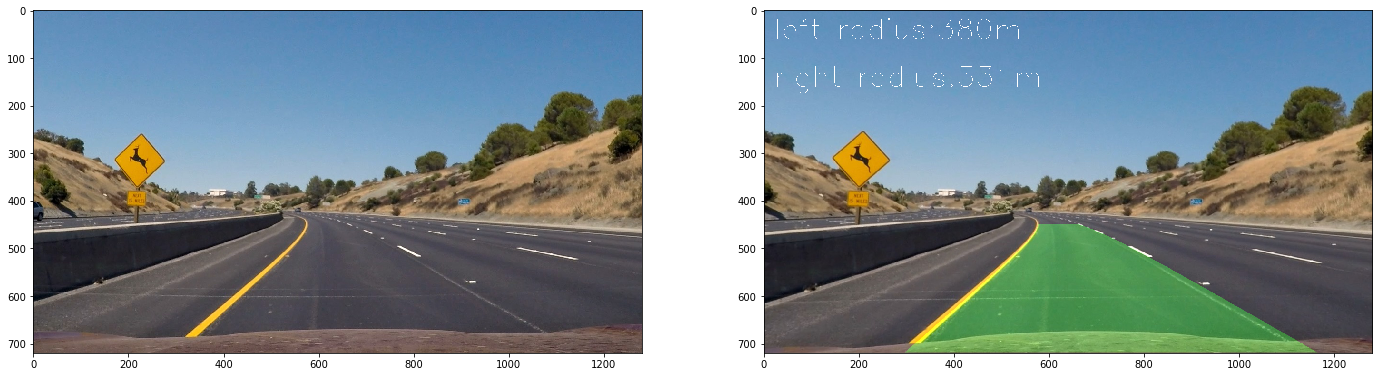

In [289]:
#apply to different images
img = mpimg.imread('test_images/test2.jpg')
result = detect_lane(img, mtx, dist, ksize, thresh, mag_thresh, sobel_kernel, angle_thesh, hls_thresh, M, Minv)
%matplotlib inline
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(result)



In [284]:
left_lane = Line()
right_lane = Line()
print(left_lane.line_base_pos)


None


In [290]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

clip = VideoFileClip("project_video.mp4").subclip(0,5)
clip_annotated = clip.fl_image(detect_lane_by_default)
%time clip_annotated.write_videofile("project_video_out.mp4", audio=False)



# vidcap = cv2.VideoCapture('big_buck_bunny_720p_5mb.mp4')
# success,image = vidcap.read()
# count = 0
# success = True
# while success:
#   success,image = vidcap.read()
#   print('Read a new frame: ', success)
#   cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
#   count += 1

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 99%|█████████▉| 125/126 [12:24<00:05,  5.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 12min 45s, sys: 24 s, total: 13min 9s
Wall time: 12min 25s


In [292]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_out.mp4"))

In [294]:
#complete videoclip
clip = VideoFileClip("project_video.mp4")
clip_annotated = clip.fl_image(detect_lane_by_default)
%time clip_annotated.write_videofile("project_video_out_complete.mp4", audio=False)



[MoviePy] >>>> Building video project_video_out_complete.mp4
[MoviePy] Writing video project_video_out_complete.mp4



100%|█████████▉| 1260/1261 [2:05:58<00:05,  5.95s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out_complete.mp4 

CPU times: user 2h 9min 27s, sys: 4min, total: 2h 13min 27s
Wall time: 2h 5min 59s


In [295]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("project_video_out_complete.mp4"))